[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/Regularization.ipynb)


# Regularization

We saw that linear least squares can be seen as maximizing the likelihood $L(w) = \prod_{(x,y) \in \mathcal{D}} p(y|x, w)$, where $p(y|x;w)$ is a Gaussian with the mean $w^\top x$ and fixed variance. In logistic regression $p(y|x, w)$ is a Bernoulli distribution with mean $\sigma(w^\top x)$.
In both cases we find the maximum likelihood solution. Instead of maximizing the likelihood, we can find the maximum of the posterior over model parameters. That is we have the prior $p(w)$, as well as the likelihood $p(y| X, w) = \prod_{x,y \in \mathcal{D}} p(y|x, w)$. Using Bayes rule the posterior is *proportional* to the product of these two terms $p(w| X,y) \propto p(w) p(y|X, w)$. Maximizing the logarithm of the posterior becomes

\begin{equation}
\arg\max_w \log L(w) + \log p(w) = \arg\min_w  J(w) - \log p(w)
\end{equation}

where the cost function $J(w)$ (e.g., L2 or cross-entropy cost) is the negative of the log-likelihood.
We see that different choices of prior $p(w)$ simply add different types of penalty to our original cost function.
Choosing an isotropic Gaussian prior $p(w) = \prod_d \mathcal{N}(w_d|0, \frac{1}{\lambda})$ gives us L2 regularization:

\begin{equation}
\log p(w) = \sum_d \log \mathcal{N}(w_d|0, \frac{1}{\lambda}) = - \frac{\lambda}{2} \sum_d w_d^2 + \mathrm{constant}
\end{equation}

where the constant terms are additive terms that do not depend on $w$. 
Similarly, using **Laplace prior** $p(w) = \frac{1}{2 \beta} \prod_d \exp \left (\frac{|w|}{\beta} \right)$ gives L1 regularization:

\begin{equation}
\log p(w) = - {\lambda} \sum_d |w_d| + \mathrm{constant}
\end{equation}

where we set $\lambda = \frac{1}{\beta}$.

Below let's see the effect of this penalty term on the landscape of the regularized cost function in working with toy data.

In [134]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import itertools

import random
np.random.seed(1234)

# Linear regression and non-linear basis functions

In [135]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]                         #add a dimension for the features
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    #add bias by adding a constant feature of value 1
        #alternatively: self.w = np.linalg.inv(x.T @ x)@x.T@y
        self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference
        return self

    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w                             #predict the y values
        return yh


# Nonlinear basis functions
Consider the toy dataset below. It is obvious that our attempt to model $y$ as a linear function of $x$ would produce a bad fit.
Let's try!

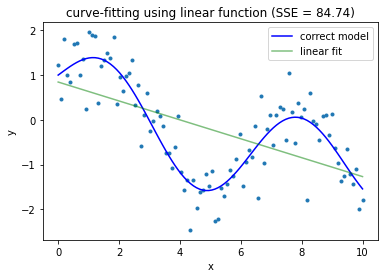

In [136]:
N = 100
x = np.linspace(0,10, N)
yt = np.sin(x) + np.cos(x**.5)
y = yt + .5*np.random.randn(N)                      #generate y using a non linear model and add noise
model = LinearRegression()
yh = model.fit(x,y).predict(x)
plt.plot(x, y, '.')
plt.plot(x, yt, 'b-', label='correct model')
plt.plot(x, yh, 'g-', alpha=.5, label='linear fit')

sse = np.square(yh - y).sum()
plt.title(f'curve-fitting using linear function (SSE = {sse:.2f})')

plt.xlabel('x')
plt.ylabel(r'y')
plt.legend()
# plt.show()
plt.savefig('sin.png', bbox_inches="tight", dpi=300)

In [137]:
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

one way around this is to create new features, and create a better fit using them. Right now we only have a single feature 'x' and we have a poor fit.
We can create new features out of existing ones. In this case, we create features that are Gaussian-like functions of 'x', where each feature has a different mean.
These are called non-linear bases, because each new feature is a non-linear function of the existing one.
Note that there are many other features that you can build to better fit this data. Below, we build ten such features with 10 different mean values.
By doing this our new design matrix (called `Phi` below) had 10 features (+1 intercept that is added in the `LinearRegression` class).
Below, let's plot these non-linear bases.

[ 0.  5. 10.]


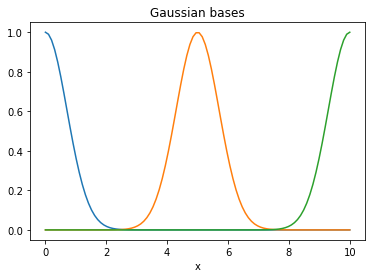

In [138]:
D=3
gaussian = lambda x,mu,sigma: np.exp(-((x-mu)/sigma)**2)          #non-linear feature function
mu = np.linspace(0,10,D)                                          #different mean values for the non-linear features
phi = gaussian(x[:,None], mu[None,:],1)                           #gives a new set of features of the existing data
for d in range(D):
    plt.plot(x, phi[:,d], '-')
plt.xlabel('x')
plt.title('Gaussian bases')
# plt.show()
plt.savefig('gaussian_basis.png', bbox_inches="tight", dpi=300)

print(mu)

Now we predict `y` using `phi` as input features rather than `x`:

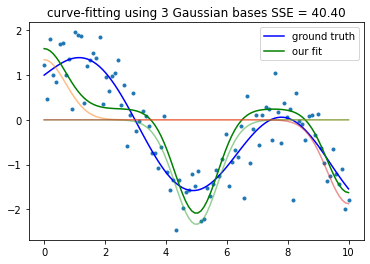

In [139]:
yh = model.fit(phi,y).predict(phi)

plt.plot(x, y, '.')
plt.plot(x, yt, 'b-', label='ground truth')
plt.plot(x, yh, 'g-', label='our fit')
for d in range(D):
    plt.plot(x, model.w[d]*phi[:,d], '-', alpha=.5)
plt.legend()
sse = np.square(yh - y).sum()
plt.title(f'curve-fitting using {D} Gaussian bases SSE = {sse:.2f}')

plt.savefig(f'{D}_gaussian_bases_fit.png', bbox_inches="tight", dpi=300)

Let's try increase the bases function to 5, 10, 50, and 200.

<Figure size 432x288 with 0 Axes>

<Figure size 345.6x201.6 with 0 Axes>

<Figure size 345.6x201.6 with 0 Axes>

<Figure size 345.6x201.6 with 0 Axes>

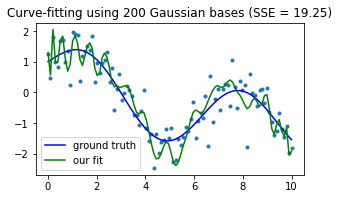

In [140]:
weight_list = []

for D in [5,10,50,200]:

    mu = np.linspace(0,10,D)                                          #different mean values for the non-linear features
    phi = gaussian(x[:,None], mu[None,:],1)                           #gives a new set of features of the existing data

    yh = model.fit(phi,y).predict(phi)

    weight_list.append(model.w) # store the model weights

    plt.clf()
    plt.figure(figsize=(4.8, 2.8))
    plt.plot(x, y, '.')
    plt.plot(x, yt, 'b-', label='ground truth')
    plt.plot(x, yh, 'g-', label='our fit')
    plt.legend()

    sse = np.square(yh - y).sum()
    plt.title(f'Curve-fitting using {D} Gaussian bases (SSE = {sse:.2f})')

    plt.savefig(f'{D}_gaussian_bases_fit.png', bbox_inches="tight", dpi=300)

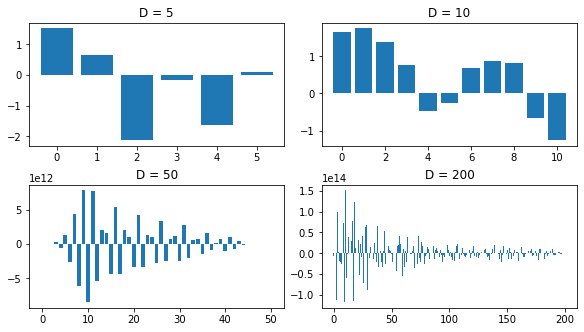

In [141]:
_, axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(8, 4.5))
axes[0,0].bar([i for i in range(len(weight_list[0]))], weight_list[0].tolist()); axes[0,0].set_title('D = 5')
axes[0,1].bar([i for i in range(len(weight_list[1]))], weight_list[1].tolist()); axes[0,1].set_title('D = 10')
axes[1,0].bar([i for i in range(len(weight_list[2]))], weight_list[2].tolist()); axes[1,0].set_title('D = 50')
axes[1,1].bar([i for i in range(len(weight_list[3]))], weight_list[3].tolist()); axes[1,1].set_title('D = 200')

plt.savefig('gaussian_bases_weights.png', bbox_inches="tight", dpi=300)

# Ridge regression

Let's create a toy data:

In [142]:
N = 20
x = np.random.rand(N) * 10
y = -4*x + 10 + 2*np.random.randn(N)

visualize the regularized **cost function** 

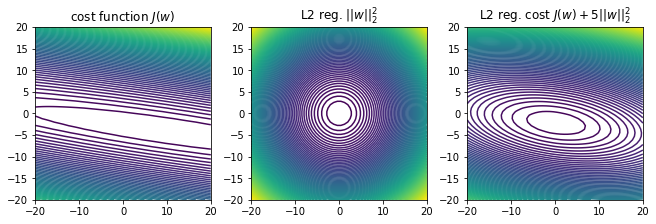

In [143]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
l2_penalty = lambda w: np.dot(w,w)/2
l1_penalty = lambda w: np.sum(np.abs(w))
cost_plus_l2 = lambda w: cost(w) + 5*l2_penalty(w)

_, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(9, 3))
plot_contour(cost, [-20,20], [-20,20], 50, axes[0])
axes[0].set_title(r'cost function $J(w)$')
plot_contour(l2_penalty, [-20,20], [-20,20], 50, axes[1])
axes[1].set_title(r'L2 reg. $||w||_2^2$')
plot_contour(cost_plus_l2, [-20,20], [-20,20], 50, axes[2])
axes[2].set_title(r'L2 reg. cost $J(w) + 5 ||w||_2^2$')
plt.savefig('l2_contour_plots.png', bbox_inches="tight", dpi=300)

Let's use the `GradientDescent` and `LinearRegression` classes from the previous lecture. The only update we have made is in using `l2_reg` which sets the regularization coefficient $\lambda$ for L2 regularization. This information is used when calculating the gradient to perform weight decay. Note that a good practice is to *avoid penalizing the bias* $w_0$. Here, for the sake of visualization we penalize the bias as well.

In [144]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []
            
    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)
            w = w - self.learning_rate * grad
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w
    
class RidgeRegression:
    def __init__(self, add_bias=True, l2_reg=0):
        self.add_bias = add_bias
        self.l2_reg = l2_reg
        pass
            
    def fit(self, x, y, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        def gradient(x, y, w):
            yh =  x @ w 
            N, D = x.shape
            grad = .5*np.dot(yh - y, x)/N
            grad += self.l2_reg* w
            return grad
        w0 = np.zeros(D)
        self.w = optimizer.run(gradient, x, y, w0)
        return self

    def fit_closedform(self, x, y):
        if x.ndim == 1:
            x = x[:, None]                         #add a dimension for the features

        N = x.shape[0]

        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    #add bias by adding a constant feature of value 1

        D = x.shape[1]
        if self.l2_reg==0:
            self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference
        else:
            self.w = np.linalg.inv(x.T @ x + self.l2_reg * np.identity(D)) @ x.T @ y

        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

Now let's visualize the landscape of regularized cost function for different amounts of regularization and see the effect of regularization on gradient descent.

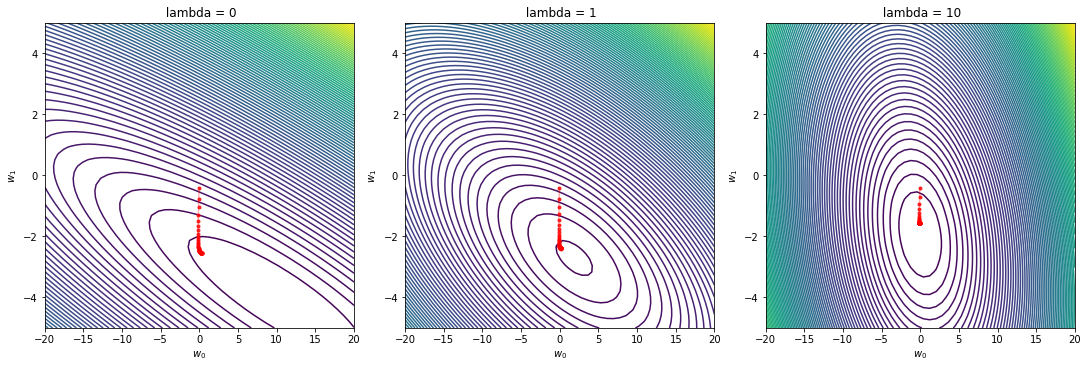

In [145]:
cost = lambda w, reg: .5*np.mean((w[0] + w[1]*x - y)**2) + reg*np.dot(w,w)/2
reg_list = [0, 1, 10]
fig, axes = plt.subplots(ncols=len(reg_list), nrows=1, constrained_layout=True, figsize=(15, 5))
for i, reg_coef in enumerate(reg_list):
    optimizer = GradientDescent(learning_rate=.01, max_iters=50, record_history=True)
    model = RidgeRegression(optimizer, l2_reg=reg_coef)
    model.fit(x,y, optimizer)
    current_cost = lambda w: cost(w, reg_coef)
    plot_contour(current_cost, [-20,20], [-5,5], 50, axes[i])
    w_hist = np.vstack(optimizer.w_history)# T x 2
    axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
    axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(f' lambda = {reg_coef}')
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-5,5])
plt.show()

The plots show that L2 regularization helps with the convergence of gradient descent.

# Fitting Gaussian bases using ridge regression

<Figure size 432x288 with 0 Axes>

<Figure size 345.6x201.6 with 0 Axes>

<Figure size 345.6x201.6 with 0 Axes>

<Figure size 345.6x201.6 with 0 Axes>

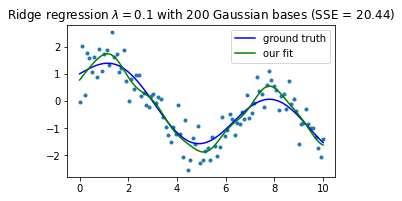

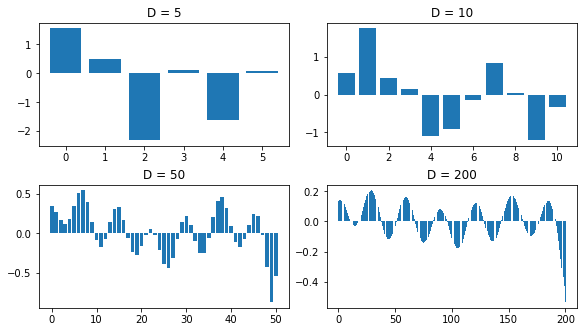

In [146]:
N = 100
x = np.linspace(0,10, N)
yt = np.sin(x) + np.cos(x**.5)
y = yt + .5*np.random.randn(N)                      #generate y using a non linear model and add noise

weight_list = []

optimizer = GradientDescent(learning_rate=.01, max_iters=50, record_history=False)

for D in [5, 10, 50, 200]:

    model = RidgeRegression(l2_reg=0.1)
    mu = np.linspace(0,10,D)                                          #different mean values for the non-linear features
    phi = gaussian(x[:,None], mu[None,:],1)                           #gives a new set of features of the existing data

    yh = model.fit_closedform(phi,y).predict(phi)

    weight_list.append(model.w) # store the model weights

    plt.clf()
    plt.figure(figsize=(4.8, 2.8))
    plt.plot(x, y, '.')
    plt.plot(x, yt, 'b-', label='ground truth')
    plt.plot(x, yh, 'g-', label='our fit')
    plt.legend()

    sse = np.square(yh - y).sum()
    plt.title(f'Ridge regression $\lambda=0.1$ with {D} Gaussian bases (SSE = {sse:.2f})')

    plt.savefig(f'{D}_gaussian_bases_ridge.png', bbox_inches="tight", dpi=300)

_, axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(8, 4.5))
axes[0,0].bar([i for i in range(len(weight_list[0]))], weight_list[0].tolist()); axes[0,0].set_title('D = 5')
axes[0,1].bar([i for i in range(len(weight_list[1]))], weight_list[1].tolist()); axes[0,1].set_title('D = 10')
axes[1,0].bar([i for i in range(len(weight_list[2]))], weight_list[2].tolist()); axes[1,0].set_title('D = 50')
axes[1,1].bar([i for i in range(len(weight_list[3]))], weight_list[3].tolist()); axes[1,1].set_title('D = 200')

plt.savefig('gaussian_bases_weights_ridge.png', bbox_inches="tight", dpi=300)

<Figure size 432x288 with 0 Axes>

<Figure size 345.6x201.6 with 0 Axes>

<Figure size 345.6x201.6 with 0 Axes>

<Figure size 345.6x201.6 with 0 Axes>

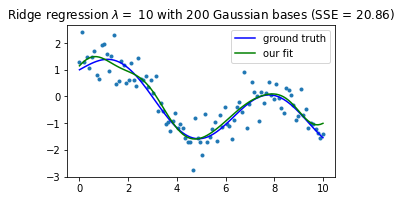

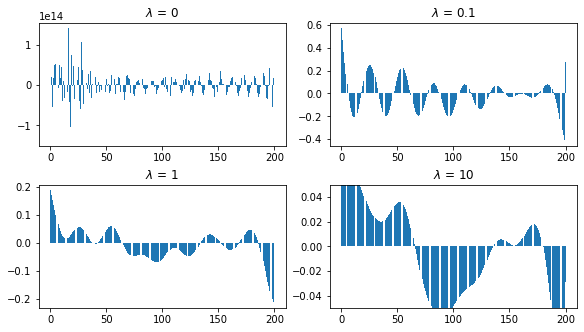

In [147]:
N = 100
x = np.linspace(0,10, N)
yt = np.sin(x) + np.cos(x**.5)
y = yt + .5*np.random.randn(N)                      #generate y using a non linear model and add noise

weight_list = []

D = 200

mu = np.linspace(0,10,D)                                          #different mean values for the non-linear features
phi = gaussian(x[:,None], mu[None,:],1)                           #gives a new set of features of the existing data

for l2 in [0, 0.1, 1, 10]:

    model = RidgeRegression(l2_reg=l2)
    yh = model.fit_closedform(phi,y).predict(phi)

    weight_list.append(model.w) # store the model weights

    plt.clf()
    plt.figure(figsize=(4.8, 2.8))
    plt.plot(x, y, '.')
    plt.plot(x, yt, 'b-', label='ground truth')
    plt.plot(x, yh, 'g-', label='our fit')
    plt.legend()

    sse = np.square(yh - y).sum()
    plt.title(f'Ridge regression $\lambda=$ {l2} with {D} Gaussian bases (SSE = {sse:.2f})')

    plt.savefig(f'{D}_gaussian_bases_ridge_lambda{l2}.png', bbox_inches="tight", dpi=300)

_, axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(8, 4.5))
axes[0,0].bar([i for i in range(len(weight_list[0]))], weight_list[0].tolist()); axes[0,0].set_title(f'$\lambda$ = 0')
axes[0,1].bar([i for i in range(len(weight_list[1]))], weight_list[1].tolist()); axes[0,1].set_title('$\lambda$ = 0.1')
axes[1,0].bar([i for i in range(len(weight_list[2]))], weight_list[2].tolist()); axes[1,0].set_title('$\lambda$ = 1')
axes[1,1].bar([i for i in range(len(weight_list[3]))], weight_list[3].tolist()); axes[1,1].set_title('$\lambda$ = 10')
plt.ylim(-0.05,0.05)

plt.savefig('gaussian_bases_weights_ridge_lambda.png', bbox_inches="tight", dpi=300)